# Vectors
_____________________________________________

## Interacting with Vectors
_______________________________

The Descartes Labs [Vectors](https://docs.descarteslabs.com/descarteslabs/vectors/readme.html) service is a tool to interact with objects that have a geospatial extent (polygons, points) and key-value properties. Common vector data might be polygons, lines, and points. Common data that might be represented as vector data include country boundries, rivers, and roads. The DL vector service allows GeoJSON geometries to include numeric or text property fields which is useful for labeling objects. Vectors is also designed to scale well to collections with hundreds of millions of entries. Here we will investigate the [Microsoft Buildings dataset](https://blogs.bing.com/maps/2018-06/microsoft-releases-125-million-building-footprints-in-the-us-as-open-data), a set of 125 million building footprints.

A [FeatureCollection](https://docs.descarteslabs.com/descarteslabs/vectors/docs/featurecollection.html) is a proxy object for accesssing millions of features within a vector product. We can list the available products that are visable to us using [list](https://docs.descarteslabs.com/descarteslabs/vectors/docs/featurecollection.html#descarteslabs.vectors.featurecollection.FeatureCollection.list).

In [1]:
import descarteslabs as dl
fc_list = dl.vectors.FeatureCollection.list()
len(fc_list)

65

In [2]:
for fc in fc_list[:3]:
    print(fc.name)

noaa_tornado_reports
us_congressional_districts_area
us_cities_area


To access a specific product, we can call a FeatureCollection with a product id. 

In [3]:
buildings = dl.vectors.FeatureCollection('a35126a241bd022c026e96ab9fe5e0ea23967d08:USBuildingFootprints')

In [4]:
buildings

FeatureCollection({
  'description': 'This dataset contains 125,192,184 computer...//github.com/Microsoft/USBuildingFootprints',
  'id': 'a35126a241bd022c026e96ab9fe5e0ea23967d08:USBuildingFootprints',
  'name': None,
  'title': 'Computer generated building footprints for the United States'
})

In [5]:
buildings.count()

125192180

Because the product contains so many vector objects, it would be impossible to work with all of them at once. Instead we can query for those we need. Like with Scenes, we can specify a region of interest and limit our data to only vectors within that region. Below we specify a neighborhood in Naples, Florida.

In [6]:
feature = {
    "type":"Feature",
    "geometry":{
        "type":"Polygon",
        "coordinates":[[
            [-81.78796863660682,26.127869173557826],
            [-81.78312992971043,26.127857614741302],
            [-81.78319001224008,26.12398143467182],
            [-81.7848036281357,26.123280163811074],
            [-81.7854559413681,26.12092201264997],
            [-81.78557610511778,26.11692229519099],
            [-81.78842568371326,26.116244101898687],
            [-81.7903482912661,26.121222564053838],
            [-81.78796863660682,26.127869173557826]
        ]]
    },
    "properties": {}
}
fc = {"type": "FeatureCollection", "features": [feature], "properties": {}}

In [25]:
from ipyleaflet import Map, GeoJSON
m = Map(center=(26.12325, -81.78678), zoom=15)
m.add_layer(GeoJSON(data=fc))
m

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

We can apply a region of interest to a FeatureCollection using the [filter](https://docs.descarteslabs.com/descarteslabs/vectors/docs/featurecollection.html#descarteslabs.vectors.featurecollection.FeatureCollection.list) method. This returns a new FeatureCollection bounded by the geometry.

In [8]:
naples = buildings.filter(geometry=feature)

While we have applied a filter to a FeatureCollection, we haven't retreived the features yet. The [features](https://docs.descarteslabs.com/descarteslabs/vectors/docs/featurecollection.html#descarteslabs.vectors.featurecollection.FeatureCollection.list) method returns a generator which can yield vector data matching our filter.

In [9]:
naples_buildings = [feat for feat in naples.features()]

In [10]:
len(naples_buildings)

279

There are 279 buildings in this neighborhood. Each object returned by [features](https://docs.descarteslabs.com/descarteslabs/vectors/docs/featurecollection.html#descarteslabs.vectors.featurecollection.FeatureCollection.list) is a [Feature](https://docs.descarteslabs.com/descarteslabs/vectors/docs/feature.html) object with a geometry, properties, and metadata. 

In [11]:
naples_buildings[0].geojson

{'properties': {},
 'geometry': {'type': 'Polygon',
  'coordinates': (((-81.785801, 26.123023),
    (-81.785746, 26.12301),
    (-81.785724, 26.123082),
    (-81.785914, 26.123127),
    (-81.785964, 26.122962),
    (-81.785828, 26.12293),
    (-81.785801, 26.123023)),)},
 'id': '89d3b86362b22d237f40f1248f77b23918b527abd4ce6c713b74162e58161796_9e6a8352f2324e5c',
 'type': 'Feature'}

A Feature's geometry field references is a Python shapely object.

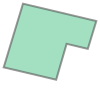

In [12]:
naples_buildings[0].geometry

## Building Footprint Area Analysis
______________________

Let's now do a simple analysis with the building footprints - calculating the area in square meters of the building extent. This simple metric is trickier than one would think because we have to convert the units from square degrees to a more natural unit. Because a unit of degrees lat by lon maps to a different area at different places on the Earth, we will have to reproject the coordinates.

Reprojecting is relatively easy to do with a package called `pyproj`. We initialize the projection with our original coordinate system. EPSG codes are often used to denote significant projection systems. Check out a list of EPSG codes [here](https://spatialreference.org/ref/epsg/). The target is an equal area projection which perserves true areas of objects across the globe (though it may distorts angles and scales).

In [13]:
import pyproj
from shapely.ops import transform
from functools import partial

def get_area(geom):
    geom_aea = transform(
    partial(
        pyproj.transform,
        pyproj.Proj(init='EPSG:4326'),
        pyproj.Proj(
            proj='aea',
            lat_1=geom.bounds[1],
            lat_2=geom.bounds[3])),
    geom)
    return geom_aea.area

With the new projection, we can transform the shapely geometry object and calculate the area in the appropriate units.

In [14]:
# area in square meters
get_area(naples_buildings[0].geometry)

311.7928349240006

In [15]:
# area in square feet
get_area(naples_buildings[0].geometry) * 10.7639

3356.10689583845

In [16]:
naples_areas = [get_area(feat.geometry) for feat in naples_buildings]

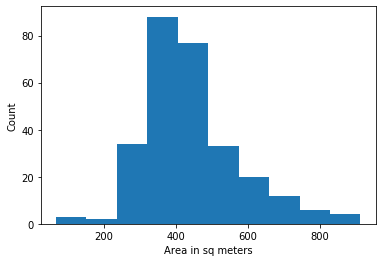

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(naples_areas)
plt.xlabel('Area in sq meters')
plt.ylabel('Count')
pass

For this neighborhood, the median building area is around 400 square meters with a long right tail and a few very small structures.

## Working with GeoJSONs
____________________

We are often interested in doing analysis over collections of Features. One handy library to work with vector data is [GeoPandas](http://geopandas.org/). Let's first write out our Features into a GeoJSON FeatureCollection.

In [18]:
naples_fc = {"type": "FeatureCollection", "features": [], "properties": {}}
for feat in naples_buildings:
    f = feat.geojson 
    f['properties']['area'] = get_area(feat.geometry)
    naples_fc['features'].append(f)

We can save our data to read in later as a GeoJSON file. 

In [19]:
import json
filename = 'naples_file.geojson'
with open(filename, 'w') as f:
    json.dump(naples_fc, f)

We can now read our data into a dataframe.

In [20]:
import geopandas
filename = 'naples_file.geojson'
naples_df = geopandas.read_file(filename)

In [21]:
naples_df.head()

,id,area,geometry
0,89d3b86362b22d237f40f1248f77b23918b527abd4ce6c...,311.792835,"POLYGON ((-81.78580100000001 26.123023, -81.78..."
1,89d3b86362b22d237f40f1248f77b23918b527abd4ce6c...,373.213458,"POLYGON ((-81.784938 26.126033, -81.785127 26...."
2,89d3b86362b22d237f40f1248f77b23918b527abd4ce6c...,307.380580,"POLYGON ((-81.787291 26.123906, -81.787396 26...."
3,89d3b86362b22d237f40f1248f77b23918b527abd4ce6c...,618.988746,"POLYGON ((-81.78627 26.12073, -81.786492999999..."
4,89d3b86362b22d237f40f1248f77b23918b527abd4ce6c...,287.411760,"POLYGON ((-81.785388 26.122478, -81.785534 26...."


We can compute aggregated stats over columns with a `pandas` like interface.

In [22]:
naples_df['area'].median()

414.1909843819785

It's also easy to make a plot of our buildings with the plot method in geopandas. Buildings are colored by area. We can see from this visualization that many of the buildings with low area are detached garages or similar.

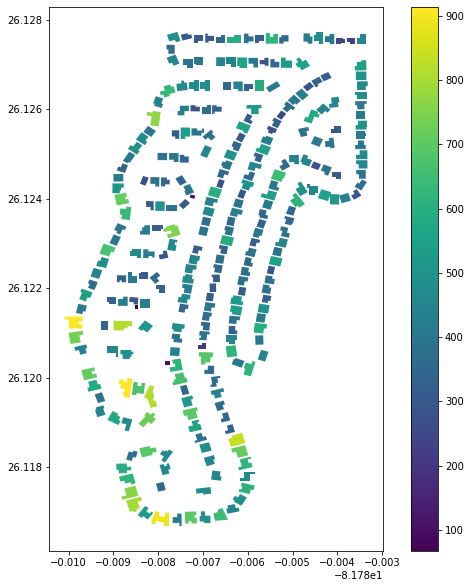

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
naples_df.plot(column='area', ax=ax, legend=True)
pass

## Creating New FeatureCollections
__________________________

For small collection of data, we can read and write GeoJSON files. For larger collections of vector data, we will want to save our data as a new FeatureCollection. We can do that by using the [create](https://docs.descarteslabs.com/descarteslabs/vectors/docs/featurecollection.html#descarteslabs.vectors.featurecollection.FeatureCollection.create) method, specifying our new product id. In this example, we'll add a new product that represents the building areas we calculated in the previous section. 

In [32]:
name = 'buildings-demo'
new_fc = dl.vectors.FeatureCollection.create(
    product_id=name, 
    title='Buildings with Areas', 
    description='A demo FeatureCollection with building footprints and areas'
)

FeatureCollections that are created by you can be found with ids that are prepended by a special user hash. These ids are useful as a way to retrieve the original product at a later time. The [list](https://docs.descarteslabs.com/descarteslabs/vectors/docs/featurecollection.html#descarteslabs.vectors.featurecollection.FeatureCollection.create) method will also show products that you have created. 

In [33]:
pid = dl.Auth().namespace + ':' + name
new_fc = dl.vectors.FeatureCollection(pid)

Our new product has no data in it yet. We can add features to our product with the [add](https://docs.descarteslabs.com/descarteslabs/vectors/docs/featurecollection.html#descarteslabs.vectors.featurecollection.FeatureCollection.create) method. For uploading a large number of features consider using [upload](https://docs.descarteslabs.com/descarteslabs/vectors/docs/featurecollection.html#descarteslabs.vectors.featurecollection.FeatureCollection.create) as well.

In [34]:
new_fc.count()

0

In [35]:
buildings_with_area = []
for feat in naples_buildings:
    feat.properties['area'] = int(get_area(feat.geometry))
    buildings_with_area.append(feat)

In [36]:
new_fc.add(buildings_with_area)
pass

In [37]:
new_fc.count()

279

Finally, we can retrieve features using the [filter](https://docs.descarteslabs.com/descarteslabs/vectors/docs/featurecollection.html#descarteslabs.vectors.featurecollection.FeatureCollection.filter) command again, now filtering over the area field.

In [38]:
from descarteslabs import properties as p
small_buildings = [feat for feat in (new_fc.filter(properties=(p.area < 100))).features()]

In [39]:
len(small_buildings)

3

In [40]:
for feat in small_buildings:
    print(feat.properties['area'])

98
67
81


There are three buildings with areas less than 100 square meters. When we are done with a FeatureCollection product, we can remove it and all the data it contains using the [delete](https://docs.descarteslabs.com/descarteslabs/vectors/docs/featurecollection.html#descarteslabs.vectors.featurecollection.FeatureCollection.delete) method. 

In [41]:
new_fc.delete()

## Wrap Up
______________________

In this notebook, we have investigated building areas using a building footprint dataset. In the process we have:

* Used [FeatureCollection.list](https://docs.descarteslabs.com/descarteslabs/vectors/docs/featurecollection.html#descarteslabs.vectors.featurecollection.FeatureCollection.list) to find available Vector products.
* Used [FeatureCollection.count](https://docs.descarteslabs.com/descarteslabs/vectors/docs/featurecollection.html#descarteslabs.vectors.featurecollection.FeatureCollection.count) to count total number of features.
* Used [FeatureCollection.filter](https://docs.descarteslabs.com/descarteslabs/vectors/docs/featurecollection.html#descarteslabs.vectors.featurecollection.FeatureCollection.filter) to narrow down our search critera over areas of interest or properties.
* Retrieve vectors using [FeatureCollection.features](https://docs.descarteslabs.com/descarteslabs/vectors/docs/featurecollection.html#descarteslabs.vectors.featurecollection.FeatureCollection.features)
* Used [Feature.geometry](https://docs.descarteslabs.com/descarteslabs/vectors/docs/feature.html#descarteslabs.vectors.feature.Feature.geometry) to find the area of the buildings after reprojecting with `pyproj`.
* Used [Feature.geojson](https://docs.descarteslabs.com/descarteslabs/vectors/docs/feature.html#descarteslabs.vectors.feature.Feature.geojson) to write out our Features into disk and read them back in with `geopandas`.
* Add new properties to [Feature.properties](https://docs.descarteslabs.com/descarteslabs/vectors/docs/feature.html#descarteslabs.vectors.feature.Feature.properties).
* Created a new Feature Collection with [FeatureCollection.create](https://docs.descarteslabs.com/descarteslabs/vectors/docs/featurecollection.html#descarteslabs.vectors.featurecollection.FeatureCollection.create).
* Add new data to a FeatureCollection with 
[FeatureCollection.add](https://docs.descarteslabs.com/descarteslabs/vectors/docs/featurecollection.html#descarteslabs.vectors.featurecollection.FeatureCollection.add).
* Removed a FeatureCollection with [FeatureCollection.delete](https://docs.descarteslabs.com/descarteslabs/vectors/docs/featurecollection.html#descarteslabs.vectors.featurecollection.FeatureCollection.delete).

## Resources
_______________

[1] [Microsoft Buildings information](https://blogs.bing.com/maps/2018-06/microsoft-releases-125-million-building-footprints-in-the-us-as-open-data)

[2] [Vectors documentation](https://blogs.bing.com/maps/2018-06/microsoft-releases-125-million-building-footprints-in-the-us-as-open-data)